# Automatic Grader with Azure OpenAI ChatGPT
This notebook can grade students’ assignments automatically by downloading them from Moodle LMS. It will unzip the assignment file from Moodle and create a folder for each student. If a student submits a zip file, it will also unzip it in their folder. The folder should contain either some Docx files or one PDF file. For Docx files, the notebook will extract and merge all the texts into one answer. For PDF files, it will only extract the text from the first page as the answer.

The notebook will then use a marking scheme as prompts and let Azure OpenAI ChatGPT evaluate the answer according to the rules. It will also estimate the probability that the answer is copied from the internet or generated by AI.

The notebook will use Azure OpenAI text-embedding-ada-002 to get the embedding of the answer. It will then use K-means clustering to group the answers based on their embeddings and show the teachers the different types of answers. It will also perform PCA on the embeddings and plot the first three principal components in 3D. This will help the teachers see how similar or different the answers are.

### Install packages

In [28]:
%pip install -q pypandoc docx2txt PyPDF2 openpyxl python-dotenv openai num2words matplotlib plotly scipy scikit-learn pandas tiktoken ipywidgets seaborn ipympl
%load_ext dotenv
%dotenv

Note: you may need to restart the kernel to use updated packages.
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### Common Functions

In [1]:
# read text file and return the content
def read_text_file(path):
    with open(path, 'r') as file:
        data = file.read().replace('\n', '')
    return data

def write_text_to_file(path, content):
    with open(path, 'w') as file:
        file.write(content)

Extract all submissions to a tmp folder


In [2]:
# Import the zipfile module
from zipfile import ZipFile
# Create a zip file object using ZipFile class
with ZipFile("data/submission.zip", "r") as zip_obj:
    # Extract all the files into a directory
    zip_obj.extractall("tmp/") 

In [3]:
# Import the os module
import os
import pandas as pd

# Define the path to list
temp_path = "tmp/submission/"

def is_folder_contains_file(folder_path, extension): 
    # Get a list of all files and directories in the path 
    names = os.listdir(folder_path) 
    for name in names: 
        if name.endswith(extension): 
            return True 
    return False   
    
# Get a list of all files and directories in the path
def get_submissions_df(path):
    assignment_folders = []
    names = os.listdir(path)
    # Loop through the list
    for name in names:
        # Join the path and the name
        full_path = os.path.join(path, name)
        # Check if it is a directory
        if os.path.isdir(full_path):
            # Print the directory name
            assignment_folders.append({
                "Student": name.split("_")[0],
                "Path": full_path,
                "ContainsDocxFile": is_folder_contains_file(full_path, ".docx"),                
                "ContainsPdfFile": is_folder_contains_file(full_path, ".pdf"),
                "ContainsZipFile": is_folder_contains_file(full_path, ".zip")
                })
    df = pd.DataFrame([p for p in assignment_folders])
    return df
df = get_submissions_df(temp_path)

In [4]:
df

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile
0,NG Man Hei,tmp/submission/NG Man Hei_2461662_assignsubmis...,False,True,False
1,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False
2,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False
3,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False
4,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False
...,...,...,...,...,...
67,HUI Man Chun,tmp/submission/HUI Man Chun_2461600_assignsubm...,True,False,False
68,CHEUNG Ka Kwai,tmp/submission/CHEUNG Ka Kwai_2461642_assignsu...,True,False,False
69,LAU Yuen Ting,tmp/submission/LAU Yuen Ting_2461612_assignsub...,True,False,False
70,LI Hoi Yung,tmp/submission/LI Hoi Yung_2461659_assignsubmi...,True,False,False


### Ensure that all the files submitted are valid

In [5]:
def filter_df_by_not_contains_any_expected_files(df):
    return df[(df["ContainsDocxFile"] == False) & (df["ContainsPdfFile"] == False) & (df["ContainsZipFile"] == False)]
filter_df_by_not_contains_any_expected_files(df)

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile


Handle zip file.

In [6]:
import os
import shutil

def flatten(directory):
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(directory, filename)

            while os.path.exists(target):
                i += 1
                file_parts = os.path.splitext(os.path.basename(filename))

                target = os.path.join(
                    directory,
                    file_parts[0] + "_" + str(i) + file_parts[1],
                )

            shutil.move(source, target)

            print("Moved ", source, " to ", target)

        if dirpath != directory:
            os.rmdir(dirpath)
            print("Deleted ", dirpath)

def get_first_file_path(path, ext):
    names = os.listdir(path)
    for name in names:
        if name.endswith(ext):
            return os.path.join(path, name)

def extract_zip_file_in_place(path):
    zip_path = get_first_file_path(path, ".zip")
    print(zip_path)
    import zipfile
    # Create a zip file object using ZipFile class
    with zipfile.ZipFile(zip_path, "r") as zip_obj:
        # Extract all the files into a directory
        zip_obj.extractall(path)
    flatten(path) 


def filter_df_by_contains_zip_file(df):
    return df[(df["ContainsZipFile"] == True)]

paths = filter_df_by_contains_zip_file(df)["Path"].values
for path in paths:
    extract_zip_file_in_place(path)

tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456.zip
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456.zip  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456_1.zip
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_Writing.docx  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_Writing_1.docx
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_VideoLink.docx  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_VideoLink_1.docx
tmp/submission/MOU Rong_2461616_assignsubmission_file_/ITP4121 Cloud and Data Centre Workplace Practices.zip
Moved  tmp/submission/MOU Rong_2461616_assignsubmission_file_/┬╛│⌡/ITP4121 Cloud and Data Centre Workplace Practices_Mou Rong.docx  to  tmp/submission/MOU Rong_2461616_assignsubmission_file_/ITP4121 Cloud and Data Centre Workplace Practi

In [7]:
df = get_submissions_df(temp_path)
## check all rows contains Docx or PDF file
def filter_df_by_contains_docx_or_pdf_file(df):
    return df[(df["ContainsDocxFile"] == True) | (df["ContainsPdfFile"] == True)]

filter_df_by_contains_docx_or_pdf_file(df)

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile
0,NG Man Hei,tmp/submission/NG Man Hei_2461662_assignsubmis...,False,True,False
1,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False
2,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False
3,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False
4,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False
...,...,...,...,...,...
67,HUI Man Chun,tmp/submission/HUI Man Chun_2461600_assignsubm...,True,False,False
68,CHEUNG Ka Kwai,tmp/submission/CHEUNG Ka Kwai_2461642_assignsu...,True,False,False
69,LAU Yuen Ting,tmp/submission/LAU Yuen Ting_2461612_assignsub...,True,False,False
70,LI Hoi Yung,tmp/submission/LI Hoi Yung_2461659_assignsubmi...,True,False,False


## Processing Docx files

In [8]:
def filter_df_by_contains_docx(df):
    return df[(df["ContainsDocxFile"] == True)]
words_df = filter_df_by_contains_docx(df)
paths = words_df["Path"].values

def get_all_docx_files(path):
    import glob
    return glob.glob(path + "/*.docx")

import docx2txt
from functools import reduce

students_words_files = list(map(get_all_docx_files, paths)) # List of lists of word files

file_contents =[];
for word_files in students_words_files:  
    file_contents.append(reduce(lambda x, y: x + y, map(lambda f: docx2txt.process(f), word_files), "\n\n"))
# reduce(map(lambda f: docx2txt.process(f), word_files), lambda x, y: x + y, "")
words_df.loc[:, "Sources"] = students_words_files
words_df.loc[:, "Answers"] = file_contents


/tmp/ipykernel_1371/1956843748.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words_df.loc[:, "Sources"] = students_words_files
/tmp/ipykernel_1371/1956843748.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words_df.loc[:, "Answers"] = file_contents


In [9]:
def filter_df_by_contains_pdf(df):
    return df[(df["ContainsPdfFile"] == True)]
pdfs_df = filter_df_by_contains_pdf(df)
paths = pdfs_df["Path"].values

def get_add_pdf_files(path):
    import glob
    return glob.glob(path + "/*.pdf")

import PyPDF2
from functools import reduce

def convert_pdf_all_pages_to_txt(path):
    pdfFileObj = open(path, 'rb')
    reader = PyPDF2.PdfReader(pdfFileObj)
    num_pages = len(reader.pages)
    count = 0
    text = ""
    while count < num_pages:
        pageObj = reader.pages[count]
        count += 1
        text += pageObj.extract_text()
        text += "\n\n"
    return text

students_pdf_files = list(map(get_add_pdf_files, paths)) # List of lists of word files

file_contents =[];
for pdf_files in students_pdf_files:
    file_contents.append(reduce(lambda x, y: x + y, map(convert_pdf_all_pages_to_txt, pdf_files), "\n\n"))

pdfs_df.loc[:, "Sources"] = students_pdf_files
pdfs_df.loc[:, "Answers"] = file_contents
pdfs_df


/tmp/ipykernel_1371/333760499.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdfs_df.loc[:, "Sources"] = students_pdf_files
/tmp/ipykernel_1371/333760499.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdfs_df.loc[:, "Answers"] = file_contents


,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers
0,NG Man Hei,tmp/submission/NG Man Hei_2461662_assignsubmis...,False,True,False,[tmp/submission/NG Man Hei_2461662_assignsubmi...,"\n\nAs a system engineer, my job responsibilit..."
8,FU Kit Lun,tmp/submission/FU Kit Lun_2461636_assignsubmis...,False,True,False,[tmp/submission/FU Kit Lun_2461636_assignsubmi...,\n\nI T P 4 1 2 1\nC l o u d\na n d\nD a t a\n...
19,KWAN Wan Loi,tmp/submission/KWAN Wan Loi_2461627_assignsubm...,True,True,False,[tmp/submission/KWAN Wan Loi_2461627_assignsub...,\n\nName: Kwan Wan Loi\nStudent id:210092959\n...
20,LO Fu Hon,tmp/submission/LO Fu Hon_2461619_assignsubmiss...,True,True,False,[tmp/submission/LO Fu Hon_2461619_assignsubmis...,\n\nJob Responsibility and Roles \nI am respo...
31,NAWAZ Raheem,tmp/submission/NAWAZ Raheem_2461598_assignsubm...,False,True,False,[tmp/submission/NAWAZ Raheem_2461598_assignsub...,"\n\nAs an intern at GTI, my role as a System A..."
45,CHONG Ka Fai,tmp/submission/CHONG Ka Fai_2461660_assignsubm...,False,True,False,[tmp/submission/CHONG Ka Fai_2461660_assignsub...,\n\nI will focus on the following items for th...
49,ZENG Haoxuan,tmp/submission/ZENG Haoxuan_2461633_assignsubm...,True,True,False,[tmp/submission/ZENG Haoxuan_2461633_assignsub...,\n\nITP4121 -Assignment -EA3 ...
54,LEE Kai,tmp/submission/LEE Kai_2461644_assignsubmissio...,False,True,False,[tmp/submission/LEE Kai_2461644_assignsubmissi...,\n\n\n\n\n\n\n\n\n\n


In [10]:
# combine two dataframes into one and export to excel
df_answers = pd.concat([words_df, pdfs_df])
df_answers.to_excel("data/answers.xlsx", index=False)

## Grading students’ responses using Azure OpenAI ChatGPT

In [11]:
import os
import json
import openai
openai.api_type = "azure"
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT") 
openai.api_version = "2023-03-15-preview"
openai.api_key = os.getenv("AZURE_OPENAI_KEY")


def grade_answer(student,student_answer, marking_scheme):    
    prompt=marking_scheme.replace("<ANSWER></ANSWER>", student_answer)
    try:
        response = openai.ChatCompletion.create(
            engine="gpt-35-turbo", # engine = "deployment_name".
            messages=[
                {"role": "system", "content": "You are a teaching assistant."},
                {"role": "user", "content": prompt},      
            ]
        )
        # print(response)
        # print(response['choices'][0]['message']['content'])
        write_text_to_file(f"tmp/{student}.json", json.dumps(response))
        tokens = response['usage']['total_tokens']
        content = json.loads(response['choices'][0]['message']['content'])
        marks = content['marks']
        comments = content['comments']       
        copyFromInternet = content['copyFromInternet']
        generativeAI = content['generativeAI']             
        return marks, comments, copyFromInternet, generativeAI, tokens, False    
    except Exception as e:
        print(e)
        return 0, "Error", 0, 0, 0, True


def grade_answers(df_answers, marking_scheme):
    for index, row in df_answers.iterrows():      
        student = row["Student"]
        print(student)
        answer = row["Answers"]
       
        marks, comments, copyFromInternet, generativeAI, tokens, error = grade_answer(student, answer, marking_scheme)
        df_answers.loc[index, "Marks"] = marks
        df_answers.loc[index, "Comments"] = comments
        df_answers.loc[index, "CopyFromInternet"] = copyFromInternet
        df_answers.loc[index, "GenerativeAI"] = generativeAI
        df_answers.loc[index, "ChatGptTokens"] = tokens     
        df_answers.loc[index, "Error"] = error
    return df_answers

marking_scheme = read_text_file("marking_scheme.txt")

# get second row answer for df_answers
# student = df_answers.iloc[[2]]["Student"].values[0]
# student_answer = df_answers.iloc[[2]]["Answers"].values[0]
# print(student_answer)
# grade_answer(student_answer, marking_scheme)

df_marked = grade_answers(df_answers, marking_scheme)
df_marked.to_excel("data/marks.xlsx", index=False)

LEUNG Chun Wa
CHEUNG Chi Him
NG Man Chun
CHAN Hiu Po
IP Siu Fung Ernest
CHENG Sin On
LIU Ka Kwan
ZHANG Jinwei
WONG Kam Shing
TO Lon San
LI Chun Ming
CHU Ka Sing
WONG Yim Wai
CHAN Ho Fung
TSOI Hoi Shing
KAN Nin Chun
ZHONG Chak Kei
KWAN Wan Loi
LO Fu Hon
CHU Hau Shing James
LEE Chun Hin
KWOK Kam Ting
CHEONG Wai Lok
CHAN Ka Ho
CHUI Yuet Sing
MOU Rong
SHIU Chung Hei
TSANG Tsz Yau
LIN Ka Ho
BUI Hai Long
TAM Ka Ho
YING Ji Kit
SHUM Chun Yiu
LIU Hok Lai
CHEUNG Nga Yin
LUAN Ho Yin
NG Cheuk Hei
OR Man Yi
YU Nga Man
OR Ho Lam
FUNG Chi Wing
MAK Wing Chung
HO Cheuk Hei
CHAN Ka Wing
LUM Shing Fung
ZENG Haoxuan
CHOW Tung Kit
MA Ka Ho
TSANG Chun Hung
CHEUNG Yui Hang
LEUNG Yu Ho
LEE Chi Kin
LAI Tsz Shing
WONG Hang Kit
LEE Kam Chun Jerry
LEUNG Pui Lam
NG Chester
WONG Tsz Chun
YUN Ka Lok
SHUM Chi Ho
WONG Kai Chung
LI Hoi Ming
HUI Man Chun
CHEUNG Ka Kwai
LAU Yuen Ting
LI Hoi Yung
MANG Kai Yuen
NG Man Hei
FU Kit Lun
This model's maximum context length is 8192 tokens. However, your messages resulted in 1367

In [12]:
df_marked

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers,Marks,Comments,CopyFromInternet,GenerativeAI,ChatGptTokens,Note,Error
1,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False,[tmp/submission/LEUNG Chun Wa_2461652_assignsu...,\n\nITP4121 Workplace Reflective Journal\n\nLe...,50.0,Great job! Your answer is well-structured and ...,0.00,0.0,1432.0,0.0,False
2,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False,[tmp/submission/CHEUNG Chi Him_2461641_assigns...,\n\nJob Responsibility and Roles\n\nWorkplace ...,50.0,Great job! Your answer shows good understandin...,0.10,0.2,2037.0,0.2,False
3,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False,[tmp/submission/NG Man Chun_2461585_assignsubm...,\n\nITP4121 Cloud and Data Centre Workplace Pr...,45.0,Your answer displays a good understanding of y...,0.20,0.0,2363.0,0.0,False
4,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False,[tmp/submission/CHAN Hiu Po_2461655_assignsubm...,\n\nChan HiuPo 210151024\n\n\n\nTable of conte...,50.0,"Overall, the student has provided a decent ans...",0.00,0.0,1816.0,0.0,False
5,IP Siu Fung Ernest,tmp/submission/IP Siu Fung Ernest_2461586_assi...,True,False,False,[tmp/submission/IP Siu Fung Ernest_2461586_ass...,\n\nIP Siu Fung Ernest (210123688)\n\nIT114115...,60.0,Great job! Your answer is thorough and demonst...,0.00,0.0,2084.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,LO Fu Hon,tmp/submission/LO Fu Hon_2461619_assignsubmiss...,True,True,False,[tmp/submission/LO Fu Hon_2461619_assignsubmis...,\n\nJob Responsibility and Roles \nI am respo...,59.0,This is a well-written and comprehensive answe...,0.00,0.0,4431.0,0,False
31,NAWAZ Raheem,tmp/submission/NAWAZ Raheem_2461598_assignsubm...,False,True,False,[tmp/submission/NAWAZ Raheem_2461598_assignsub...,"\n\nAs an intern at GTI, my role as a System A...",60.0,Great job! Your answer is well-organized and p...,0.05,0.3,1737.0,0.3,False
45,CHONG Ka Fai,tmp/submission/CHONG Ka Fai_2461660_assignsubm...,False,True,False,[tmp/submission/CHONG Ka Fai_2461660_assignsub...,\n\nI will focus on the following items for th...,50.0,Great reflection! You provided a clear and con...,0.00,0.0,1976.0,0,False
49,ZENG Haoxuan,tmp/submission/ZENG Haoxuan_2461633_assignsubm...,True,True,False,[tmp/submission/ZENG Haoxuan_2461633_assignsub...,\n\nITP4121 -Assignment -EA3 ...,50.0,"Overall, this is a well-structured and thought...",0.00,0.3,2020.0,0.3,False


## Embeddings and clustering

In [2]:
import openai
import os
import re
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding
import tiktoken

API_KEY = os.getenv("AZURE_OPENAI_KEY") 
RESOURCE_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 

openai.api_type = "azure"
openai.api_key = API_KEY
openai.api_base = RESOURCE_ENDPOINT
openai.api_version = "2022-12-01"

url = openai.api_base + "/openai/deployments?api-version=2022-12-01" 

In [12]:
df_marked = pd.read_excel("data/marks.xlsx") 
df_Answers = df_marked[['Student','Answers']]
df_Answers

,Student,Answers
0,LEUNG Chun Wa,\n\nITP4121 Workplace Reflective Journal\n\nLe...
1,CHEUNG Chi Him,\n\nJob Responsibility and Roles\n\nWorkplace ...
2,NG Man Chun,\n\nITP4121 Cloud and Data Centre Workplace Pr...
3,CHAN Hiu Po,\n\nChan HiuPo 210151024\n\n\n\nTable of conte...
4,IP Siu Fung Ernest,\n\nIP Siu Fung Ernest (210123688)\n\nIT114115...
...,...,...
70,LO Fu Hon,\n\nJob Responsibility and Roles \nI am respo...
71,NAWAZ Raheem,"\n\nAs an intern at GTI, my role as a System A..."
72,CHONG Ka Fai,\n\nI will focus on the following items for th...
73,ZENG Haoxuan,\n\nITP4121 -Assignment -EA3 ...


Data cleaning by removing redundant whitespace and cleaning up

In [13]:
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()    
    return s if len(s) > 0 else "Do nothing"

df_Answers['Answers']= df_Answers["Answers"].apply(lambda x : normalize_text(x))

Remove any answers that are too long for the token limit (8192 tokens).

In [65]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df_Answers['n_tokens'] = df_Answers["Answers"].apply(lambda x: len(tokenizer.encode(x)))
df_Answers = df_Answers[df_Answers.n_tokens<8192]
len(df_Answers)

74

In [66]:
df_Answers


,Student,Answers,n_tokens
0,LEUNG Chun Wa,ITP4121 Workplace Reflective Journal Leung Chu...,655
1,CHEUNG Chi Him,Job Responsibility and Roles Workplace experie...,1237
2,NG Man Chun,ITP4121 Cloud and Data Centre Workplace Practi...,1532
3,CHAN Hiu Po,Chan HiuPo 210151024 Table of contents Job Res...,986
4,IP Siu Fung Ernest,IP Siu Fung Ernest (210123688) IT114115/2B ITP...,1307
...,...,...,...
70,LO Fu Hon,Job Responsibility and Roles I am responsible ...,3264
71,NAWAZ Raheem,"As an intern at GTI, my role as a System Admin...",860
72,CHONG Ka Fai,I will focus on the following items for this r...,1128
73,ZENG Haoxuan,ITP4121 -Assignment -EA3 IT114115 -2B name : Z...,1082


In [67]:
df_Answers['ada_v2'] = df_Answers["Answers"].apply(lambda x : get_embedding(x, engine = 'text-embedding-ada-002')) 
# df_Answers.set_index( ['Student'], inplace = True)
# engine should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model

In [85]:
import json
df_Answers.to_excel("data/embeddings.xlsx", index=True)
df_Answers.apply(lambda x : write_text_to_file(f"tmp/embeddings_{x.Student}.json", json.dumps(x.ada_v2)), axis=1)
df_Answers

,Student,Answers,n_tokens,ada_v2
0,LEUNG Chun Wa,ITP4121 Workplace Reflective Journal Leung Chu...,655,"[0.010281223803758621, -0.010676655918359756, ..."
1,CHEUNG Chi Him,Job Responsibility and Roles Workplace experie...,1237,"[-0.012838901951909065, -0.027127781882882118,..."
2,NG Man Chun,ITP4121 Cloud and Data Centre Workplace Practi...,1532,"[0.007017713040113449, -0.02948104590177536, 0..."
3,CHAN Hiu Po,Chan HiuPo 210151024 Table of contents Job Res...,986,"[0.002446548081934452, -0.003825077321380377, ..."
4,IP Siu Fung Ernest,IP Siu Fung Ernest (210123688) IT114115/2B ITP...,1307,"[0.002623006235808134, -0.015880554914474487, ..."
...,...,...,...,...
70,LO Fu Hon,Job Responsibility and Roles I am responsible ...,3264,"[-0.007378511596471071, -0.02641216665506363, ..."
71,NAWAZ Raheem,"As an intern at GTI, my role as a System Admin...",860,"[-0.01746942475438118, -0.03845672309398651, 0..."
72,CHONG Ka Fai,I will focus on the following items for this r...,1128,"[0.0008320792112499475, -0.008383403532207012,..."
73,ZENG Haoxuan,ITP4121 -Assignment -EA3 IT114115 -2B name : Z...,1082,"[-0.00724449660629034, -0.014353200793266296, ..."


### Clustering based on the Embeddings

Reload embeddings.

In [2]:
import json
import pandas as pd
import numpy as np

# df_embeddings = df_Answers.copy()
df_embeddings = pd.read_excel("data/embeddings.xlsx") 
def reload_embeddings(student):
    return list(json.loads(read_text_file(f"tmp/embeddings_{student.Student}.json")))
df_embeddings["ada_v2"] = df_embeddings.apply(lambda s : reload_embeddings(s), axis=1)
df_embeddings.drop(['Unnamed: 0'], axis=1, inplace=True)
df_embeddings.set_index( ['Student'], inplace = True)
df_embeddings.head()

,Answers,n_tokens,ada_v2
Student,,,
LEUNG Chun Wa,ITP4121 Workplace Reflective Journal Leung Chu...,655,"[0.010281223803758621, -0.010676655918359756, ..."
CHEUNG Chi Him,Job Responsibility and Roles Workplace experie...,1237,"[-0.012838901951909065, -0.027127781882882118,..."
NG Man Chun,ITP4121 Cloud and Data Centre Workplace Practi...,1532,"[0.007017713040113449, -0.02948104590177536, 0..."
CHAN Hiu Po,Chan HiuPo 210151024 Table of contents Job Res...,986,"[0.002446548081934452, -0.003825077321380377, ..."
IP Siu Fung Ernest,IP Siu Fung Ernest (210123688) IT114115/2B ITP...,1307,"[0.002623006235808134, -0.015880554914474487, ..."


In [3]:
from sklearn.cluster import KMeans

matrix = np.array(df_embeddings["ada_v2"].to_list())
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init='auto')
kmeans.fit(matrix)
labels = kmeans.labels_
df_embeddings["Cluster"] = labels 
df_embeddings.head()

,Answers,n_tokens,ada_v2,Cluster
Student,,,,
LEUNG Chun Wa,ITP4121 Workplace Reflective Journal Leung Chu...,655,"[0.010281223803758621, -0.010676655918359756, ...",4
CHEUNG Chi Him,Job Responsibility and Roles Workplace experie...,1237,"[-0.012838901951909065, -0.027127781882882118,...",4
NG Man Chun,ITP4121 Cloud and Data Centre Workplace Practi...,1532,"[0.007017713040113449, -0.02948104590177536, 0...",4
CHAN Hiu Po,Chan HiuPo 210151024 Table of contents Job Res...,986,"[0.002446548081934452, -0.003825077321380377, ...",3
IP Siu Fung Ernest,IP Siu Fung Ernest (210123688) IT114115/2B ITP...,1307,"[0.002623006235808134, -0.015880554914474487, ...",5


/tmp/ipykernel_4933/3178453947.py:19: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/home/codespace/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4933/3178453947.py:20: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


Text(0.5, 1.0, 'Embeddings visualized using t-SNE')

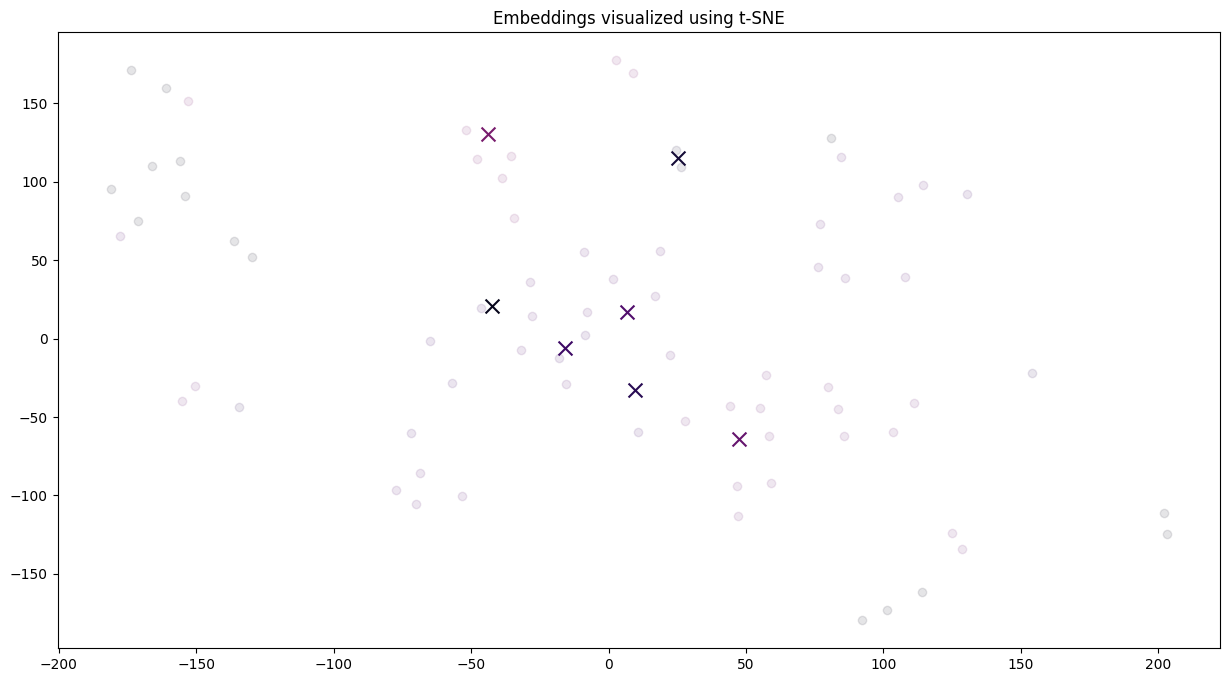

In [4]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 8) 

tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

palette = sns.color_palette("inferno", 20).as_hex() 

for category, color in enumerate(palette):    
    xs = np.array(x)[df_embeddings["Cluster"]==category]
    ys = np.array(y)[df_embeddings["Cluster"]==category]
    plt.scatter(xs, ys, color=color, alpha=0.1)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)
plt.title("Embeddings visualized using t-SNE")

Export the final result cluster

In [5]:
df_marked_tmp=pd.read_excel("data/marks.xlsx") 
df_embeddings_tmp=df_embeddings.copy()
df_marked_tmp.set_index( ['Student'], inplace = True)
# df_embeddings_tmp.set_index( ['Student'], inplace = True)
df_final = pd.merge(df_marked_tmp, df_embeddings_tmp[["n_tokens","ada_v2","Cluster"]], how='left', left_index=True, right_index=True)

cols = ['Marks', 'Comments', 'Answers','CopyFromInternet','GenerativeAI','ChatGptTokens','Error','Cluster']

df_final= df_final[cols]
df_final.to_excel("data/final.xlsx", index=True)
df_final.head(5)


,Marks,Comments,Answers,CopyFromInternet,GenerativeAI,ChatGptTokens,Error,Cluster
Student,,,,,,,,
BUI Hai Long,55,The student has provided a thorough and well-w...,\n\nITP4121\n\nCloud and Data Centre Workplace...,0.0,0.0,1873,False,5.0
CHAN Hiu Po,50,"Overall, the student has provided a decent ans...",\n\nChan HiuPo 210151024\n\n\n\nTable of conte...,0.0,0.0,1816,False,3.0
CHAN Ho Fung,55,"Overall, this is an excellent answer. The stud...",\n\nName: Chan Ho Fung\n\nClass: 2A\n\nStudent...,0.0,0.0,1641,False,5.0
CHAN Ka Ho,50,Great job! Your answer is well-organized and p...,"\n\nDuring my internship at China Telecom, I h...",0.0,0.0,1847,False,0.0
CHAN Ka Wing,25,"Overall, the student answer provides a general...",\n\nhttps://drive.google.com/file/d/1oZoMDXmSe...,0.1,0.5,844,False,2.0


### Reduce the embedding dimensionality

In [6]:
from sklearn.decomposition import PCA

pca_df = df_embeddings.copy()
matrix = pca_df["ada_v2"].to_list()
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)
pca_df["embed_vis"] = vis_dims.tolist()
pca_df

,Answers,n_tokens,ada_v2,Cluster,embed_vis
Student,,,,,
LEUNG Chun Wa,ITP4121 Workplace Reflective Journal Leung Chu...,655,"[0.010281223803758621, -0.010676655918359756, ...",4,"[-0.13679943972846306, 0.008570703636672217, -..."
CHEUNG Chi Him,Job Responsibility and Roles Workplace experie...,1237,"[-0.012838901951909065, -0.027127781882882118,...",4,"[-0.09621850429487015, -0.023004553499780093, ..."
NG Man Chun,ITP4121 Cloud and Data Centre Workplace Practi...,1532,"[0.007017713040113449, -0.02948104590177536, 0...",4,"[-0.1357489776423994, -0.03231771536693334, -0..."
CHAN Hiu Po,Chan HiuPo 210151024 Table of contents Job Res...,986,"[0.002446548081934452, -0.003825077321380377, ...",3,"[-0.05753715536938102, 0.006130565341441969, -..."
IP Siu Fung Ernest,IP Siu Fung Ernest (210123688) IT114115/2B ITP...,1307,"[0.002623006235808134, -0.015880554914474487, ...",5,"[-0.0953551017178489, -0.013742819947159363, 0..."
...,...,...,...,...,...
LO Fu Hon,Job Responsibility and Roles I am responsible ...,3264,"[-0.007378511596471071, -0.02641216665506363, ...",0,"[0.12081271533021641, -0.1922087870215897, -0...."
NAWAZ Raheem,"As an intern at GTI, my role as a System Admin...",860,"[-0.01746942475438118, -0.03845672309398651, 0...",0,"[0.12471769305090098, 0.07542707528734788, -0...."
CHONG Ka Fai,I will focus on the following items for this r...,1128,"[0.0008320792112499475, -0.008383403532207012,...",4,"[-0.08633789833722227, -0.04075133727455968, -..."


Text(0.5, 0, 'z')

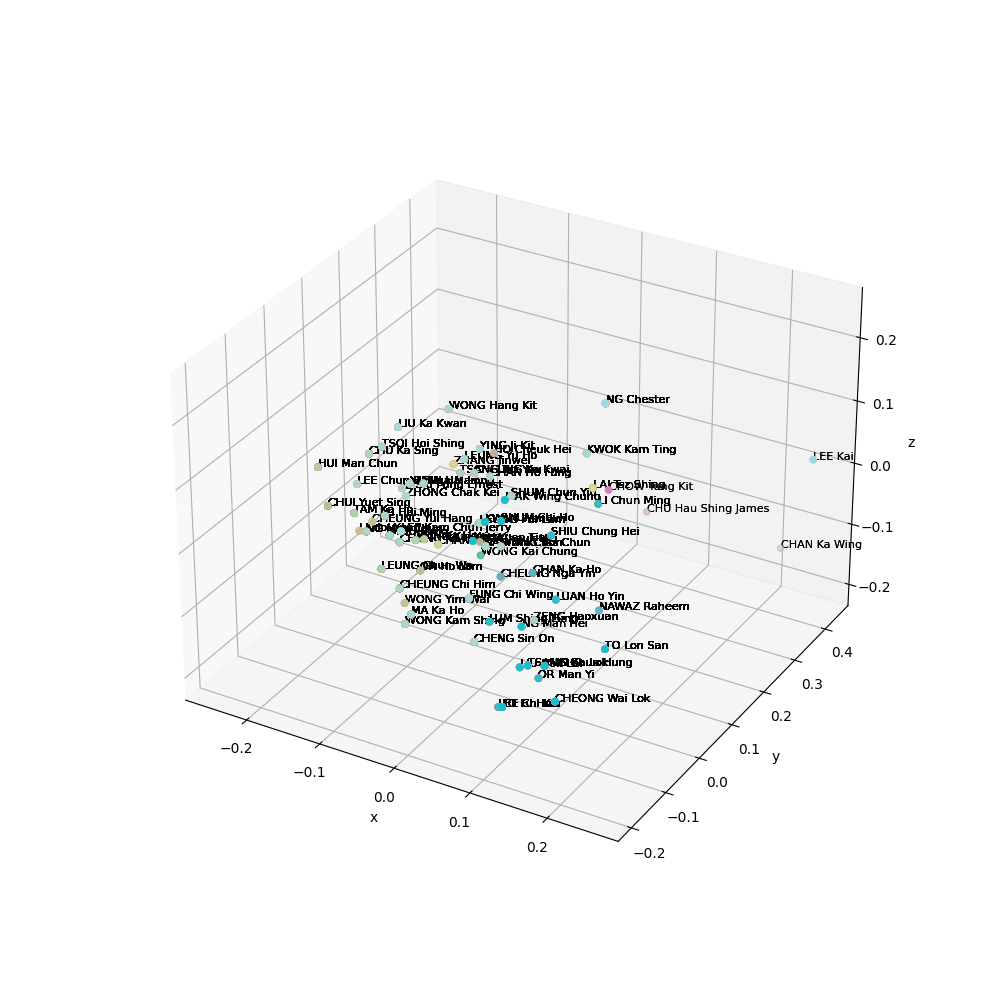

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

clusters = pca_df["Cluster"].to_list()

# Plot each sample category individually such that we can set label name.
for i, clusterId in enumerate(clusters):
    sub_matrix = np.array(pca_df[pca_df["Cluster"] == clusterId]["embed_vis"].to_list())
    
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(clusters))] * len(sub_matrix)
    ax.scatter(x, y, zs=z, zdir='z', c=colors, label=clusterId)

    students = pca_df[pca_df["Cluster"] == clusterId].index.values.tolist()
    for i, txt in enumerate(students):
        ax.text(x[i], y[i], z[i], txt, size=8, zorder=1, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend(bbox_to_anchor=(1.1, 1))